<a href="https://colab.research.google.com/github/ngoniematt/BERT-Model-for-Depression-Severity-Prediction/blob/main/BERT-TR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [ ]:
!pip install transformers
!pip install torch
!pip install emoji
!pip install contractions
!pip install huggingface_hub[hf_xet]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import random
import numpy as np
import torch
from transformers import set_seed, BertTokenizer, BertModel
from torch.optim import AdamW

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
set_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True)
except Exception as e:
    print("Could not enforce deterministic algorithms:", e)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import contractions
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


Mounted at /content/drive


In [ ]:
import pandas as pd
file_path = "/content/drive/My Drive/BERTBASE/Final_Depression.csv"
data = pd.read_csv(file_path)
data = data[['Text', 'depression_Intensity']].dropna()


In [ ]:
def expand_contractions(text):
    return contractions.fix(text)

def clean_text(text):
    text = re.sub(r'@\w+', 'at_user', text)      # Replace mentions
    text = re.sub(r'http\S+|www\S+', 'url', text)  # Replace URLs
    text = re.sub(r'\s+', ' ', text).strip()       # Remove extra spaces
    return text

def preprocess_text(text):
    text = expand_contractions(text)
    text = clean_text(text)
    return text

data["Cleaned_Text"] = data["Text"].apply(preprocess_text)

In [ ]:
def categorize_depression(intensity):
    if intensity < 0.4:
        return "Non-Depressed"
    elif 0.4 <= intensity < 0.6:
        return "Mild"
    else:
        return "Severe"

data['category'] = data['depression_Intensity'].apply(categorize_depression)


In [ ]:
# We split the data into training and temporary sets using stratification on 'category'
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['category'])
# Further split the temporary data into validation and test sets (stratified)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['category'])



In [ ]:
# Calculate class frequencies in the training data
class_counts = train_data['category'].value_counts().to_dict()
total_samples = len(train_data)
# Create a weight for each class inversely proportional to its frequency
weights_dict = {cls: total_samples / count for cls, count in class_counts.items()}
print("Class weights:", weights_dict)

# Add a new column 'sample_weight' for each training sample
train_data['sample_weight'] = train_data['category'].apply(lambda x: weights_dict[x])


Class weights: {'Mild': 1.4625992478061012, 'Severe': 4.563233376792699, 'Non-Depressed': 10.294117647058824}


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(texts.tolist(), truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")

train_encodings = encode_texts(train_data["Cleaned_Text"], tokenizer)
val_encodings = encode_texts(val_data["Cleaned_Text"], tokenizer)
test_encodings = encode_texts(test_data["Cleaned_Text"], tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Define a custom Dataset class that includes sample weights
class DepressionDataset(Dataset):
    def __init__(self, encodings, labels, weights=None):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)
        self.weights = torch.tensor(weights, dtype=torch.float) if weights is not None else None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        if self.weights is not None:
            item["weights"] = self.weights[idx]
        return item

train_dataset_weighted = DepressionDataset(train_encodings, train_data["depression_Intensity"].values, weights=train_data["sample_weight"].values)
val_dataset = DepressionDataset(val_encodings, val_data["depression_Intensity"].values)
test_dataset = DepressionDataset(test_encodings, test_data["depression_Intensity"].values)

# DataLoader reproducibility settings
def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

train_loader_weighted = DataLoader(train_dataset_weighted, batch_size=16, shuffle=True,
                                   worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,
                        worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,
                         worker_init_fn=seed_worker, generator=g)


In [ ]:
class BertRegression(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased'):
        super(BertRegression, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)  # Regression output

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.pooler_output  # Use CLS token representation
        last_hidden_state = self.dropout(last_hidden_state)
        return self.regressor(last_hidden_state)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertRegression().to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

def train_model_weighted(model, train_loader, val_loader, optimizer, epochs=20, patience=3, device="cuda"):
    best_val_loss = float("inf")
    patience_counter = 0
    min_delta = 0.00005

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            sample_weights = batch["weights"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze()
            # Compute weighted MSE loss: weight * (error^2), averaged over the batch
            loss = (sample_weights * (outputs - labels) ** 2).mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation loop (using standard MSE for evaluation)
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids, attention_mask).squeeze()
                loss = nn.functional.mse_loss(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.6f} | Val Loss = {avg_val_loss:.6f}")

        if (best_val_loss - avg_val_loss) > min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
            print("Validation loss improved. Saving model...")
            torch.save(model.state_dict(), "/content/drive/MyDrive/New_Models/DeepThresholded.pth")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement!")
            break

    print("Training complete :)")

EPOCHS = 20
PATIENCE = 3

train_model_weighted(model=model,
                     train_loader=train_loader_weighted,
                     val_loader=val_loader,
                     optimizer=optimizer,
                     epochs=EPOCHS,
                     patience=PATIENCE,
                     device=device)

Epoch 1/20: Train Loss = 0.084891 | Val Loss = 0.007658
Validation loss improved. Saving model...
Epoch 2/20: Train Loss = 0.026250 | Val Loss = 0.003596
Validation loss improved. Saving model...
Epoch 3/20: Train Loss = 0.016728 | Val Loss = 0.004194
No improvement for 1 epoch(s).
Epoch 4/20: Train Loss = 0.013098 | Val Loss = 0.002598
Validation loss improved. Saving model...
Epoch 5/20: Train Loss = 0.010170 | Val Loss = 0.004279
No improvement for 1 epoch(s).
Epoch 6/20: Train Loss = 0.008949 | Val Loss = 0.002681
No improvement for 2 epoch(s).
Epoch 7/20: Train Loss = 0.006774 | Val Loss = 0.002290
Validation loss improved. Saving model...
Epoch 8/20: Train Loss = 0.006695 | Val Loss = 0.002270
No improvement for 1 epoch(s).
Epoch 9/20: Train Loss = 0.006321 | Val Loss = 0.002324
No improvement for 2 epoch(s).
Epoch 10/20: Train Loss = 0.005043 | Val Loss = 0.002187
Validation loss improved. Saving model...
Epoch 11/20: Train Loss = 0.004828 | Val Loss = 0.002322
No improvement fo

In [ ]:
#Threshold Optimization on Validation Data
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report

def optimize_thresholds(val_loader, model, val_data, device="cuda"):
    """
    Evaluate the model on the validation set and optimize thresholds based on the original ground truth labels.

    Args:
        val_loader: DataLoader for validation data.
        model: Trained regression model.
        val_data: Original validation DataFrame containing the 'category' column.
        device: 'cuda' or 'cpu'.

    Returns:
        best_thresholds: Tuple of (low_thresh, high_thresh)
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            predictions.extend(outputs.cpu().numpy())

    predictions = np.array(predictions)

    # Use the original true categories from the validation DataFrame
    true_classes = val_data['category'].values

    best_f1 = -1
    best_thresholds = (0.4, 0.6)  # default starting thresholds

    # Grid search: candidate low thresholds between 0.3 and 0.5, high thresholds between 0.5 and 0.7
    for low in np.linspace(0.3, 0.5, num=20):
        for high in np.linspace(0.5, 0.7, num=20):
            pred_classes = [
                "Non-Depressed" if x < low
                else "Mild" if x < high
                else "Depressed"
                for x in predictions
            ]
            current_f1 = f1_score(true_classes, pred_classes, average="weighted")
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_thresholds = (low, high)

    print(f"Optimized thresholds on validation set: {best_thresholds} with weighted F1: {best_f1:.4f}")
    return best_thresholds

# Optimize thresholds using the validation set.
best_thresholds = optimize_thresholds(val_loader, model, val_data=val_data, device=device)

Optimized thresholds on validation set: (np.float64(0.3736842105263158), np.float64(0.5947368421052631)) with weighted F1: 0.6912


Loading best saved model for evaluation...
Model loaded successfully!

Evaluation Results:
Mean Squared Error (MSE): 0.0017
R² Score: 0.8265


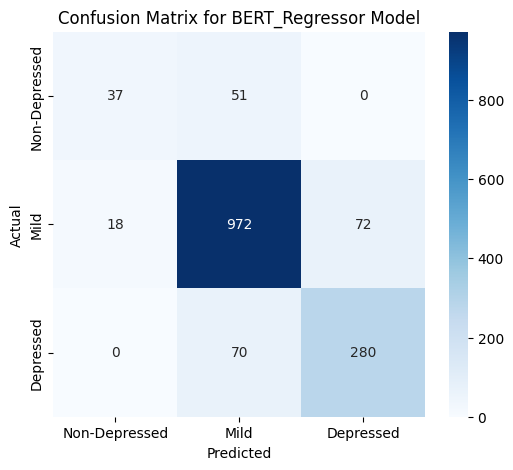


Classification Report:

               precision    recall  f1-score   support

Non-Depressed       0.80      0.80      0.80       350
         Mild       0.89      0.92      0.90      1062
    Depressed       0.67      0.42      0.52        88

     accuracy                           0.86      1500
    macro avg       0.79      0.71      0.74      1500
 weighted avg       0.85      0.86      0.86      1500



In [ ]:
#Evaluation on Test Set Using Optimized Thresholds

def evaluate_model_bert(model, test_loader, thresholds, model_path=None, device="cuda"):
    """
    Evaluate the BERT regression model on the test set using the provided optimized thresholds
    to convert continuous outputs into categorical labels.

    Args:
        model: Trained regression model.
        test_loader: DataLoader for the test data.
        thresholds: A tuple (low_thresh, high_thresh) for classification.
        model_path: Optional path to load saved model weights.
        device: "cuda" or "cpu".

    Returns:
        mse, r2: Regression performance metrics.
    """
    if model_path:
        print("Loading best saved model for evaluation...")
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Model loaded successfully!")

    low_thresh, high_thresh = thresholds
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    print(f"\nEvaluation Results:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

    def categorize_depression(intensity):
        if intensity < low_thresh:
            return "Non-Depressed"
        elif intensity < high_thresh:
            return "Mild"
        else:
            return "Depressed"

    true_labels_class = np.array([categorize_depression(val) for val in true_labels])
    predicted_labels_class = np.array([categorize_depression(val) for val in predictions])

    class_labels = ["Non-Depressed", "Mild", "Depressed"]
    cm = confusion_matrix(true_labels_class, predicted_labels_class, labels=class_labels)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for BERT_Regressor Model")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(true_labels_class, predicted_labels_class, target_names=class_labels))

    return mse, r2

# Evaluate on the test set using the optimized thresholds
mse, r2 = evaluate_model_bert(model=model,
                              test_loader=test_loader,
                              thresholds=best_thresholds,
                              model_path="/content/drive/MyDrive/New_Models/DeepThresholded.pth",
                              device=device)

In [ ]:
del model  # Delete previous model
torch.cuda.empty_cache()  # Clear GPU memory


In [ ]:
class BertRegression(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased'):
        super(BertRegression, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)  # Regression output

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.pooler_output  # Use CLS token representation
        last_hidden_state = self.dropout(last_hidden_state)
        return self.regressor(last_hidden_state)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertRegression().to(device)

In [ ]:
def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)


train_loader_weighted = DataLoader(train_dataset_weighted, batch_size=32, shuffle=True,
                                   worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                        worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         worker_init_fn=seed_worker, generator=g)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

def train_model_weighted(model, train_loader, val_loader, optimizer, epochs=20, patience=3, device="cuda"):
    best_val_loss = float("inf")
    patience_counter = 0
    min_delta = 0.00005

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            sample_weights = batch["weights"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze()
            # Compute weighted MSE loss: weight * (error^2), averaged over the batch
            loss = (sample_weights * (outputs - labels) ** 2).mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation loop (using standard MSE for evaluation)
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids, attention_mask).squeeze()
                loss = nn.functional.mse_loss(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.6f} | Val Loss = {avg_val_loss:.6f}")

        if (best_val_loss - avg_val_loss) > min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
            print("Validation loss improved. Saving model...")
            torch.save(model.state_dict(), "weightedloss_32.pth")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement!")
            break

    print("Training complete :)")

EPOCHS = 20
PATIENCE = 3

train_model_weighted(model=model,
                     train_loader=train_loader_weighted,
                     val_loader=val_loader,
                     optimizer=optimizer,
                     epochs=EPOCHS,
                     patience=PATIENCE,
                     device=device)

Epoch 1/20: Train Loss = 0.084264 | Val Loss = 0.004462
Validation loss improved. Saving model...
Epoch 2/20: Train Loss = 0.019957 | Val Loss = 0.003109
Validation loss improved. Saving model...
Epoch 3/20: Train Loss = 0.012831 | Val Loss = 0.003074
No improvement for 1 epoch(s).
Epoch 4/20: Train Loss = 0.009552 | Val Loss = 0.002840
Validation loss improved. Saving model...
Epoch 5/20: Train Loss = 0.007358 | Val Loss = 0.002848
No improvement for 1 epoch(s).
Epoch 6/20: Train Loss = 0.006475 | Val Loss = 0.002930
No improvement for 2 epoch(s).
Epoch 7/20: Train Loss = 0.005582 | Val Loss = 0.002745
Validation loss improved. Saving model...
Epoch 8/20: Train Loss = 0.004670 | Val Loss = 0.002408
Validation loss improved. Saving model...
Epoch 9/20: Train Loss = 0.004111 | Val Loss = 0.002289
Validation loss improved. Saving model...
Epoch 10/20: Train Loss = 0.003808 | Val Loss = 0.002609
No improvement for 1 epoch(s).
Epoch 11/20: Train Loss = 0.004243 | Val Loss = 0.003146
No imp

In [ ]:
#Threshold Optimization on Validation Data
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report

def optimize_thresholds(val_loader, model, val_data, device="cuda"):
    """
    Evaluate the model on the validation set and optimize thresholds based on the original ground truth labels.

    Args:
        val_loader: DataLoader for validation data.
        model: Trained regression model.
        val_data: Original validation DataFrame containing the 'category' column.
        device: 'cuda' or 'cpu'.

    Returns:
        best_thresholds: Tuple of (low_thresh, high_thresh)
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            predictions.extend(outputs.cpu().numpy())

    predictions = np.array(predictions)

    # Use the original true categories from the validation DataFrame
    true_classes = val_data['category'].values

    best_f1 = -1
    best_thresholds = (0.4, 0.6)  # default starting thresholds

    # Grid search: candidate low thresholds between 0.3 and 0.5, high thresholds between 0.5 and 0.7
    for low in np.linspace(0.3, 0.5, num=20):
        for high in np.linspace(0.5, 0.7, num=20):
            pred_classes = [
                "Non-Depressed" if x < low
                else "Mild" if x < high
                else "Depressed"
                for x in predictions
            ]
            current_f1 = f1_score(true_classes, pred_classes, average="weighted")
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_thresholds = (low, high)

    print(f"Optimized thresholds on validation set: {best_thresholds} with weighted F1: {best_f1:.4f}")
    return best_thresholds

# Optimize thresholds using the validation set.
best_thresholds = optimize_thresholds(val_loader, model, val_data=val_data, device=device)

Optimized thresholds on validation set: (np.float64(0.4052631578947368), np.float64(0.6052631578947368)) with weighted F1: 0.6835


Loading best saved model for evaluation...
Model loaded successfully!

Evaluation Results:
Mean Squared Error (MSE): 0.0019
R² Score: 0.8046


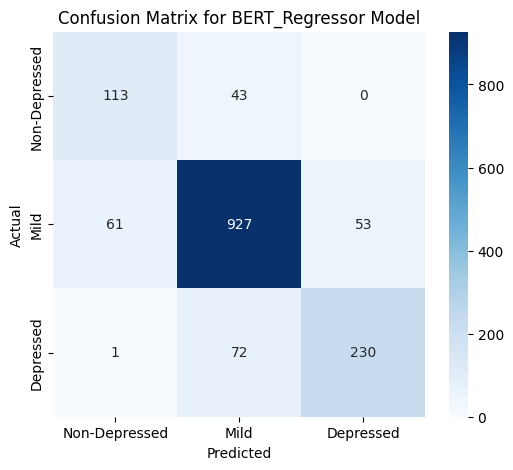


Classification Report:

               precision    recall  f1-score   support

Non-Depressed       0.81      0.76      0.78       303
         Mild       0.89      0.89      0.89      1041
    Depressed       0.65      0.72      0.68       156

     accuracy                           0.85      1500
    macro avg       0.78      0.79      0.79      1500
 weighted avg       0.85      0.85      0.85      1500



In [ ]:
#Evaluation on Test Set Using Optimized Thresholds

def evaluate_model_bert(model, test_loader, thresholds, model_path=None, device="cuda"):
    """
    Evaluate the BERT regression model on the test set using the provided optimized thresholds
    to convert continuous outputs into categorical labels.

    Args:
        model: Trained regression model.
        test_loader: DataLoader for the test data.
        thresholds: A tuple (low_thresh, high_thresh) for classification.
        model_path: Optional path to load saved model weights.
        device: "cuda" or "cpu".

    Returns:
        mse, r2: Regression performance metrics.
    """
    if model_path:
        print("Loading best saved model for evaluation...")
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Model loaded successfully!")

    low_thresh, high_thresh = thresholds
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    print(f"\nEvaluation Results:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

    def categorize_depression(intensity):
        if intensity < low_thresh:
            return "Non-Depressed"
        elif intensity < high_thresh:
            return "Mild"
        else:
            return "Depressed"

    true_labels_class = np.array([categorize_depression(val) for val in true_labels])
    predicted_labels_class = np.array([categorize_depression(val) for val in predictions])

    class_labels = ["Non-Depressed", "Mild", "Depressed"]
    cm = confusion_matrix(true_labels_class, predicted_labels_class, labels=class_labels)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for BERT_Regressor Model")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(true_labels_class, predicted_labels_class, target_names=class_labels))

    return mse, r2

# Evaluate on the test set using the optimized thresholds
mse, r2 = evaluate_model_bert(model=model,
                              test_loader=test_loader,
                              thresholds=best_thresholds,
                              model_path="weightedloss_32.pth",
                              device=device)

In [ ]:
del model  # Delete previous model
torch.cuda.empty_cache()  # Clear GPU memory


In [ ]:
class BertRegression(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased'):
        super(BertRegression, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)  # Regression output

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.pooler_output  # Use CLS token representation
        last_hidden_state = self.dropout(last_hidden_state)
        return self.regressor(last_hidden_state)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertRegression().to(device)

In [ ]:
train_loader_weighted = DataLoader(train_dataset_weighted, batch_size=64, shuffle=True,
                                   worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                        worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                         worker_init_fn=seed_worker, generator=g)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

def train_model_weighted(model, train_loader, val_loader, optimizer, epochs=20, patience=3, device="cuda"):
    best_val_loss = float("inf")
    patience_counter = 0
    min_delta = 0.00005

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            sample_weights = batch["weights"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze()
            # Compute weighted MSE loss: weight * (error^2), averaged over the batch
            loss = (sample_weights * (outputs - labels) ** 2).mean()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation loop (using standard MSE for evaluation)
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids, attention_mask).squeeze()
                loss = nn.functional.mse_loss(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.6f} | Val Loss = {avg_val_loss:.6f}")

        if (best_val_loss - avg_val_loss) > min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0
            print("Validation loss improved. Saving model...")
            torch.save(model.state_dict(), "weightedloss_64.pth")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement!")
            break

    print("Training complete :)")

EPOCHS = 20
PATIENCE = 3

train_model_weighted(model=model,
                     train_loader=train_loader_weighted,
                     val_loader=val_loader,
                     optimizer=optimizer,
                     epochs=EPOCHS,
                     patience=PATIENCE,
                     device=device)

Epoch 1/20: Train Loss = 0.188724 | Val Loss = 0.011350
Validation loss improved. Saving model...
Epoch 2/20: Train Loss = 0.057021 | Val Loss = 0.007532
Validation loss improved. Saving model...
Epoch 3/20: Train Loss = 0.040482 | Val Loss = 0.005870
Validation loss improved. Saving model...
Epoch 4/20: Train Loss = 0.028190 | Val Loss = 0.003559
Validation loss improved. Saving model...
Epoch 5/20: Train Loss = 0.021552 | Val Loss = 0.004161
No improvement for 1 epoch(s).
Epoch 6/20: Train Loss = 0.016684 | Val Loss = 0.003523
No improvement for 2 epoch(s).
Epoch 7/20: Train Loss = 0.013807 | Val Loss = 0.003203
Validation loss improved. Saving model...
Epoch 8/20: Train Loss = 0.012272 | Val Loss = 0.003215
No improvement for 1 epoch(s).
Epoch 9/20: Train Loss = 0.009982 | Val Loss = 0.003173
No improvement for 2 epoch(s).
Epoch 10/20: Train Loss = 0.008711 | Val Loss = 0.002726
Validation loss improved. Saving model...
Epoch 11/20: Train Loss = 0.007344 | Val Loss = 0.002701
No imp

In [ ]:
#Threshold Optimization on Validation Data
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report

def optimize_thresholds(val_loader, model, val_data, device="cuda"):
    """
    Evaluate the model on the validation set and optimize thresholds based on the original ground truth labels.

    Args:
        val_loader: DataLoader for validation data.
        model: Trained regression model.
        val_data: Original validation DataFrame containing the 'category' column.
        device: 'cuda' or 'cpu'.

    Returns:
        best_thresholds: Tuple of (low_thresh, high_thresh)
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            predictions.extend(outputs.cpu().numpy())

    predictions = np.array(predictions)

    # Use the original true categories from the validation DataFrame
    true_classes = val_data['category'].values

    best_f1 = -1
    best_thresholds = (0.4, 0.6)  # default starting thresholds

    # Grid search: candidate low thresholds between 0.3 and 0.5, high thresholds between 0.5 and 0.7
    for low in np.linspace(0.3, 0.5, num=20):
        for high in np.linspace(0.5, 0.7, num=20):
            pred_classes = [
                "Non-Depressed" if x < low
                else "Mild" if x < high
                else "Depressed"
                for x in predictions
            ]
            current_f1 = f1_score(true_classes, pred_classes, average="weighted")
            if current_f1 > best_f1:
                best_f1 = current_f1
                best_thresholds = (low, high)

    print(f"Optimized thresholds on validation set: {best_thresholds} with weighted F1: {best_f1:.4f}")
    return best_thresholds

# Optimize thresholds using the validation set.
best_thresholds = optimize_thresholds(val_loader, model, val_data=val_data, device=device)

Optimized thresholds on validation set: (np.float64(0.4157894736842105), np.float64(0.6368421052631579)) with weighted F1: 0.6780


Loading best saved model for evaluation...
Model loaded successfully!

Evaluation Results:
Mean Squared Error (MSE): 0.0022
R² Score: 0.7717


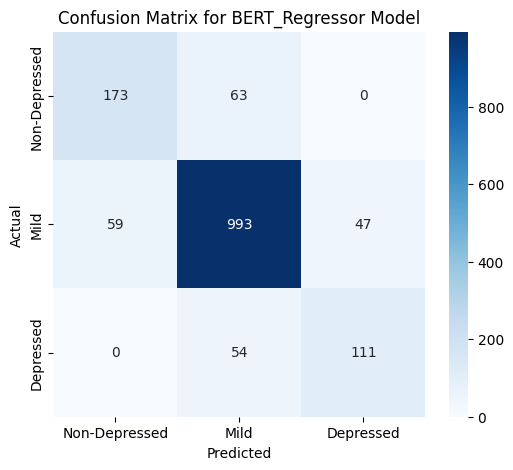


Classification Report:

               precision    recall  f1-score   support

Non-Depressed       0.70      0.67      0.69       165
         Mild       0.89      0.90      0.90      1099
    Depressed       0.75      0.73      0.74       236

     accuracy                           0.85      1500
    macro avg       0.78      0.77      0.78      1500
 weighted avg       0.85      0.85      0.85      1500



In [ ]:
#Evaluation on Test Set Using Optimized Thresholds

def evaluate_model_bert(model, test_loader, thresholds, model_path=None, device="cuda"):
    """
    Evaluate the BERT regression model on the test set using the provided optimized thresholds
    to convert continuous outputs into categorical labels.

    Args:
        model: Trained regression model.
        test_loader: DataLoader for the test data.
        thresholds: A tuple (low_thresh, high_thresh) for classification.
        model_path: Optional path to load saved model weights.
        device: "cuda" or "cpu".

    Returns:
        mse, r2: Regression performance metrics.
    """
    if model_path:
        print("Loading best saved model for evaluation...")
        model.load_state_dict(torch.load(model_path, map_location=device))
        print("Model loaded successfully!")

    low_thresh, high_thresh = thresholds
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask).squeeze()
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    print(f"\nEvaluation Results:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

    def categorize_depression(intensity):
        if intensity < low_thresh:
            return "Non-Depressed"
        elif intensity < high_thresh:
            return "Mild"
        else:
            return "Depressed"

    true_labels_class = np.array([categorize_depression(val) for val in true_labels])
    predicted_labels_class = np.array([categorize_depression(val) for val in predictions])

    class_labels = ["Non-Depressed", "Mild", "Depressed"]
    cm = confusion_matrix(true_labels_class, predicted_labels_class, labels=class_labels)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for BERT_Regressor Model")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(true_labels_class, predicted_labels_class, target_names=class_labels))

    return mse, r2

# Evaluate on the test set using the optimized thresholds
mse, r2 = evaluate_model_bert(model=model,
                              test_loader=test_loader,
                              thresholds=best_thresholds,
                              model_path="weightedloss_64.pth",
                              device=device)